# Dreambooth inpainting finetuning

Finetune Stable Diffusion inpainting model on custom images. Replace mask in any image with finetuned object.

## References
- https://www.sicara.fr/blog-technique/dataset-generation-fine-tune-stable-diffusion-inpainting
- https://github.com/huggingface/diffusers/tree/main/examples/research_projects/dreambooth_inpaint
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb

In [ ]:
!pip install -U diffusers transformers ftfy gradio accelerate

In [ ]:
!pip install torch==1.13.1 torchvision==0.14.1
#!pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/research_projects/dreambooth_inpaint/train_dreambooth_inpaint.py

**Optional**: install Detectron2 for automatic image mask generation

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [3]:
import inspect
from typing import List, Optional, Union
import numpy as np
import torch
import os
import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

Download test image and mask

In [1]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

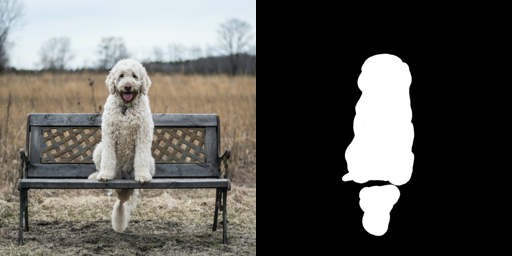

In [21]:
image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))
images = [image, mask_image]
image_grid(images, 1, 2)

In [4]:
local_dir = "./images/dog/"  # train images
inpaint_dir = "./images/inpainting/"  # target images and masks

if not os.path.exists(local_dir):
    os.makedirs(local_dir)
if not os.path.exists(inpaint_dir):
    os.makedirs(inpaint_dir)

**Optional**: download dog dataset from Huggingface

In [ ]:
from huggingface_hub import snapshot_download

local_dir = "./images/dog/"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

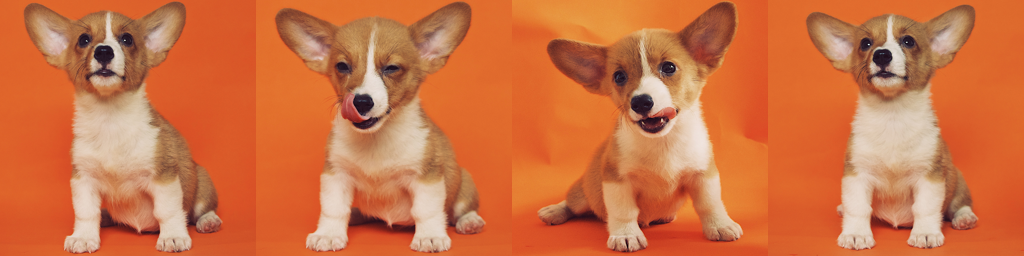

In [18]:
import glob

# change path to display images from your local dir
img_paths = f"{local_dir}*.jpeg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 4
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

Load inpainting model

In [2]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Run inpainting model

In [5]:
prompt = "a mecha robot sitting on a bench"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

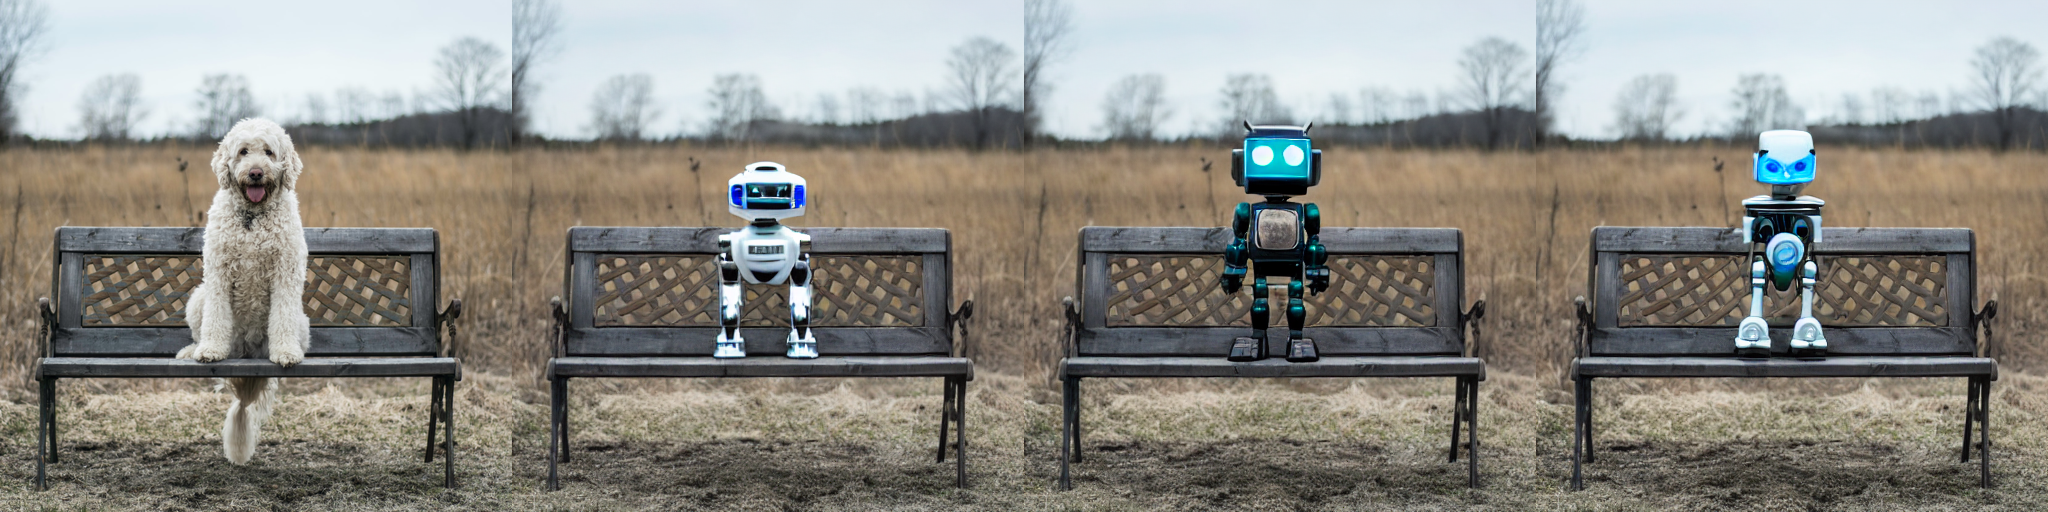

In [6]:
# insert the initial image in the list so we can compare side by side
images.insert(0, image)
image_grid(images, 1, num_samples + 1)

Log in into huggingface to save the model on the hub

In [6]:
from huggingface_hub import notebook_login
notebook_login()

Train your own inpainting model

In [43]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_inpaint.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-inpainting"  \
    --instance_data_dir="images/dog" \
    --output_dir="stable-diffusion-inpainting-dog" \
    --instance_prompt="a photo of a sks dog" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=2 \
    --gradient_checkpointing \
    --train_text_encoder \
    --push_to_hub
    --seed="0"

Steps: 100%|███████████| 400/400 [08:36<00:00,  1.31s/it, loss=0.00454, lr=5e-6]vae/diffusion_pytorch_model.safetensors not found

Loading pipeline components...:  14%|█▊           | 1/7 [00:00<00:00,  9.81it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.

Steps: 100%|███████████| 400/400 [09:18<00:00,  1.40s/it, loss=0.00454, lr=5e-6]


Test training results

In [9]:
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline

# Image and Mask
image = Image.open(os.path.join(inpaint_dir, "dog.jpg"))
mask_image = Image.open(os.path.join(inpaint_dir, "dog_mask.jpg"))

# Inpainting model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stable-diffusion-inpainting-dog",
    torch_dtype=torch.float16,
)
pipe.to(device)
n_samples = 4
images = pipe(prompt=["a photo of a sks dog"]*n_samples, image=image, mask_image=mask_image).images

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

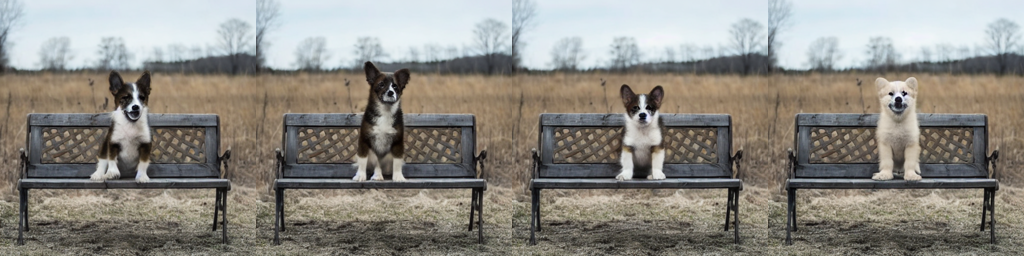

In [21]:
# insert initial image in the list so we can compare side by side
image_grid(images, 1, n_samples)

# Automatic mask creation with Detectron2

In [11]:
# First, import the necessary modules
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import numpy as np
from PIL import Image
import cv2


def predict_mask(input_path, object_class):
    im = cv2.imread(input_path)
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

    class_names = MetadataCatalog.get(cfg.DATASETS.TEST[0]).thing_classes
    assert object_class in class_names

    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)

    # Get class IDs of the instances
    class_ids = outputs["instances"].pred_classes
    predicted_class_names = np.array([class_names[i] for i in class_ids])
    indices = np.where(predicted_class_names == object_class)
    if len(indices) == 0:
        print(f'No objects of class {object_class} detected')
        return None
    if len(indices) > 1:
        print(f'{len(indices)} objects of class {object_class} detected. Selected first occurrence by default.')
    indices = indices[0]
    
    bboxes = outputs['instances'].pred_boxes.tensor[indices].cpu().numpy()
    mask = outputs['instances'].pred_masks[indices][0].cpu().numpy()

    # Store the mask of dogs found by the pointrend model
    mask_image = np.zeros(image.size)
    mask_image += mask.transpose()
    # Create a mask image bigger than the original segmented image
    mask_image += np.roll(mask_image, 10, axis=[0, 0]) # Translate the mask 10 pixels to the left
    mask_image += np.roll(mask_image, -10, axis=[0, 0]) # Translate the mask 10 pixels to the right
    mask_image += np.roll(mask_image, 10, axis=[1, 1]) # Translate the mask 10 pixels to the bottom
    mask_image += np.roll(mask_image, -10, axis=[1, 1]) # Translate the mask 10 pixels to the top
    # Set non black pixels to white pixels
    mask_image = np.clip(mask_image, 0, 1).transpose() * 255
    # Save the mask image
    mask_image = Image.fromarray(np.uint8(mask_image)).resize(image.size)
    
    return bboxes, mask, mask_image

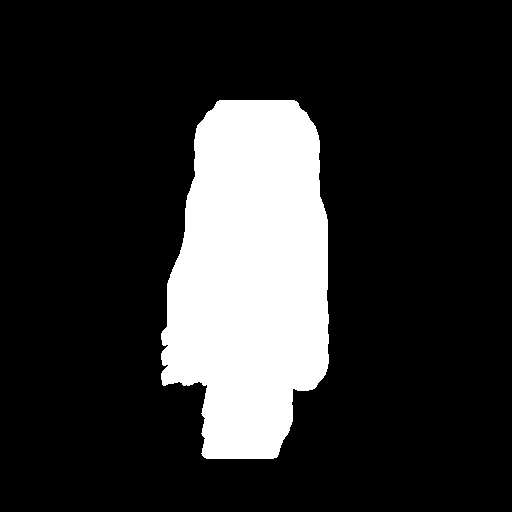

In [129]:
_, _, image_mask = predict_mask(os.path.join(inpaint_dir, "dog.jpg"), "dog")
image_mask.save(os.path.join(inpaint_dir, "dog_mask_detectron.jpg"))
image_mask

In [27]:
# Image and Mask
def inpaint(image, prompt, mask=None, n_samples=4, device='cuda', class_instance=None):
    image_pil = Image.open(os.path.join(inpaint_dir, image))
    if mask is not None:
        mask_image = Image.open(os.path.join(inpaint_dir, mask))
    elif class_instance is not None:
        mask_image = predict_mask(os.path.join(inpaint_dir, image), class_instance)[-1]
    images = pipe(prompt=[prompt]*n_samples, image=image_pil, mask_image=mask_image).images
    return images

  0%|          | 0/50 [00:00<?, ?it/s]

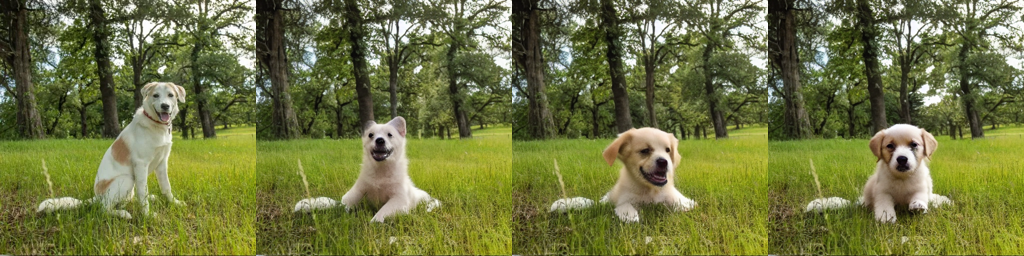

In [32]:
images = inpaint('dog_park.jpeg', prompt="a photo of a sks dog", class_instance='dog')
images.insert(0, Image.open(os.path.join(inpaint_dir, 'dog_park.jpeg')))
image_grid(images, 1, n_samples)

  0%|          | 0/50 [00:00<?, ?it/s]

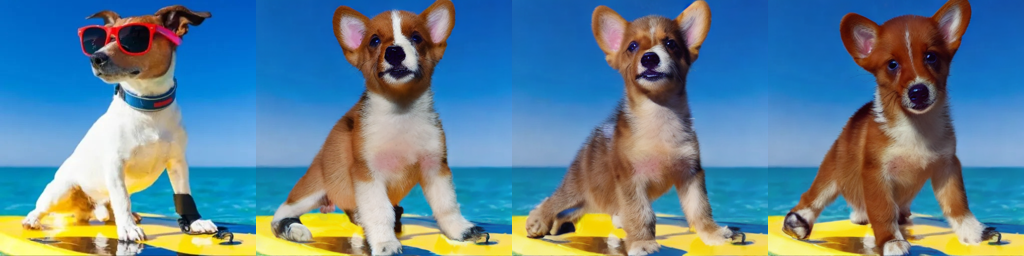

In [31]:
images = inpaint('dog_sea.jpeg', prompt="a photo of a sks dog", class_instance='dog')
images.insert(0, Image.open(os.path.join(inpaint_dir, 'dog_sea.jpeg')))
image_grid(images, 1, n_samples)

  0%|          | 0/50 [00:00<?, ?it/s]

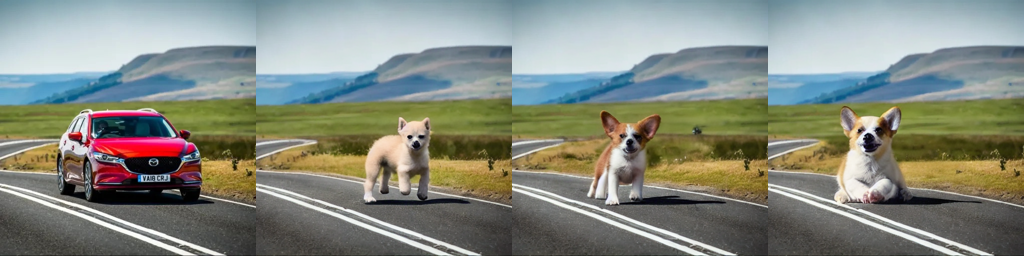

In [34]:
images = inpaint('car.jpeg', prompt="a photo of a sks dog", class_instance='car')
images.insert(0, Image.open(os.path.join(inpaint_dir, 'car.jpeg')))
image_grid(images, 1, n_samples)